In [1]:
import pandas as pd
import numpy as np
import os
import glob
import duckdb as db
import matplotlib.pyplot as plt

from helpers import load_full_df, delete_columns

import textblob as tx
from nltk.sentiment import SentimentIntensityAnalyzer
from langdetect import detect

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from transformers import TextClassificationPipeline

# from sentence_transformers import SentenceTransformer


# tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
# model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
# pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)

# model_st = SentenceTransformer('distiluse-base-multilingual-cased-v2')

CSV_DIR_STRING = 'data/csv_files/'
JSON_DIR_STRING = 'data/json_files/'
TARGET_COL_NAME = 'label'

In [2]:
def replacer(review: str) -> str:

    replace = {
                'á': 'a', 
                'é': 'e',
                'ớ': 'o',
                'ú': 'u',
                'Á': 'A',
                'É': 'E',
                'Ớ': 'O',
                'Ú': 'U'
            }
    
    for key in replace.keys():
        review = str(review).replace(key, replace[key])
    
    return review

def mx(x):

    if x == 'de':
        x = 3
    elif x == 'fr':
        x = 2
    elif x == 'en':
        x = 1
    else:
        x = np.random.randint(1, 3)
        
    return x

In [19]:
def preprocess(df, is_train=True, pipeline=None, model_st=None, do_nlp_pipeline=False):

    if is_train:
        df['vine'] = df['vine'].apply(lambda x: True if x == 'Y' else False)
        df['verified_purchase'] = df['verified_purchase'].apply(lambda x: True if x == 'Y' else False)
        # df['review_date'] = df['review_date'].astype(str)
        df['no_review_headline'] = df['review_headline'].isna()
        
        df.set_index('Unnamed: 0', drop=True, inplace=True)
        df.index.name = ''

        df['review_body'] = df.apply(lambda x: replacer(x['review_body']) if x['marketplace_id'] != 2 else x['review_body'], axis=1)
        df['review_headline'] = df.apply(lambda x: replacer(x['review_headline']) if x['marketplace_id'] != 2 else x['review_headline'], axis=1)

        df['lens'] = df['review_body'].apply(lambda x: len(x))
        df = df[df['lens'] >= 2]

        df = df[~df["review_body"].str.contains('https://')]
        df['marketplace_id'] = df.apply(lambda x: detect(x['review_body']) if x['marketplace_id'] == 0 else x['marketplace_id'], axis=1)
        df = df[~df["marketplace_id"].isin(['pt', 'sv', 'pl', 'nl', 'da', 'et', 'it', 'so', 'ca', 'af', 'fi', 'tl', 'sl', 'ro', 'sw', 'no', 'id'])]

        df['marketplace_id'] = df['marketplace_id'].apply(lambda x: mx(x))
        df['marketplace_id'] = df['marketplace_id'].astype(int)

        if do_nlp_pipeline:
            print('Creating embeddings now...')
            df['review_body_embedding'] = df['review_body'].apply(lambda x: np.mean(model_st.encode(x)))

            print('Adding stars...')
            df['stars'] = df['review_body'].apply(lambda x: int(pipeline(x[0:512])[0]['label'][0]))

    else:
        df['vine'] = df['vine'].apply(lambda x: True if x == 'Y' else False)
        df['verified_purchase'] = df['verified_purchase'].apply(lambda x: True if x == 'Y' else False)
        # df['review_date'] = df['review_date'].astype(str)
        df['no_review_headline'] = df['review_headline'].isna()
        
        df.set_index('Unnamed: 0', drop=True, inplace=True)
        df.index.name = ''

        df['review_body'] = df.apply(lambda x: replacer(x['review_body']) if x['marketplace_id'] != 2 else x['review_body'], axis=1)
        df['review_headline'] = df.apply(lambda x: replacer(x['review_headline']) if x['marketplace_id'] != 2 else x['review_headline'], axis=1)

        df['lens'] = df['review_body'].apply(lambda x: len(x))
        df = df[df['lens'] >= 2]

        df['stars'] = df['review_body'].apply(lambda x: int(pipeline(x[0:512])[0]['label'][0]))

        df = df[~df["review_body"].str.contains('https://')]
        df['marketplace_id'] = df.apply(lambda x: detect(x['review_body']) if x['marketplace_id'] == 0 else x['marketplace_id'], axis=1)
        # df = df[~df["marketplace_id"].isin(['pt', 'sv', 'pl', 'nl', 'da', 'et', 'it', 'so', 'ca', 'af', 'fi', 'tl', 'sl', 'ro', 'sw', 'no', 'id'])]

        df['marketplace_id'] = df['marketplace_id'].apply(lambda x: mx(x))
        # df['marketplace_id'] = df['marketplace_id'].astype(int)

        if do_nlp_pipeline:
        
            print('Creating embeddings now...')
            df['review_body_embedding'] = df['review_body'].apply(lambda x: np.mean(model_st.encode(x)))

            print('Adding stars...')
            df['stars'] = df['review_body'].apply(lambda x: int(pipeline(x[0:512])[0]['label'][0]))

    return df

In [56]:
df = load_full_df(CSV_DIR_STRING, JSON_DIR_STRING, load_json=True)

In [57]:
df = preprocess(df, is_train=True, pipeline=None, model_st=None)

In [58]:
def country_name_map(x):
    if x == 1:
        return 'UK'
    elif x == 2:
        return 'FR'
    elif x == 3:
        return 'DE'

In [59]:
sDF = df.copy()

In [60]:
df['country_name'] = df['id_x'].apply(lambda x: country_name_map(x))

In [61]:
delete_columns(df, ['marketplace_id', 'product_category_id', 'country_marketplace', 'id_y', 'id_x'])

In [62]:
df.head()

,product_id,product_parent,product_title,vine,verified_purchase,review_headline,review_body,review_date,category_name,label,has_review_headline,lens,country_name
,,,,,,,,,,,,,
9,B001N2MZT8,903886718,Green Zone [DVD],False,True,green zone,I found at first it was a little difficult to ...,2010-11-15,Video DVD,False,False,450,UK
145,B005ZC7BLO,501966104,Bones - Season 7 [DVD],False,True,Bones Season 7,If you already like Bones this may not be quit...,2012-12-12,Video DVD,False,False,110,UK
256,B000NTPCHE,671553677,To Catch A Thief [DVD] [1955],False,False,Lovely film,"I've always enjoyed this film, spectacular set...",2012-04-30,Video DVD,True,False,249,UK
938,B008BR79C6,410760130,Captain America [Blu-ray] [Region Free],False,True,Best of the Rest,"Surprised how much I enjoyed this movie, Capt ...",2014-03-12,Video DVD,False,False,113,UK
1097,B007I1QUYE,38597042,Spider-Man Trilogy [Blu-ray] [Region Free],False,True,AWESOME 3D,"WHAT A FANTASTIC MOVIE, WOW 3D IS AWESOME",2014-10-06,Video DVD,False,False,41,UK


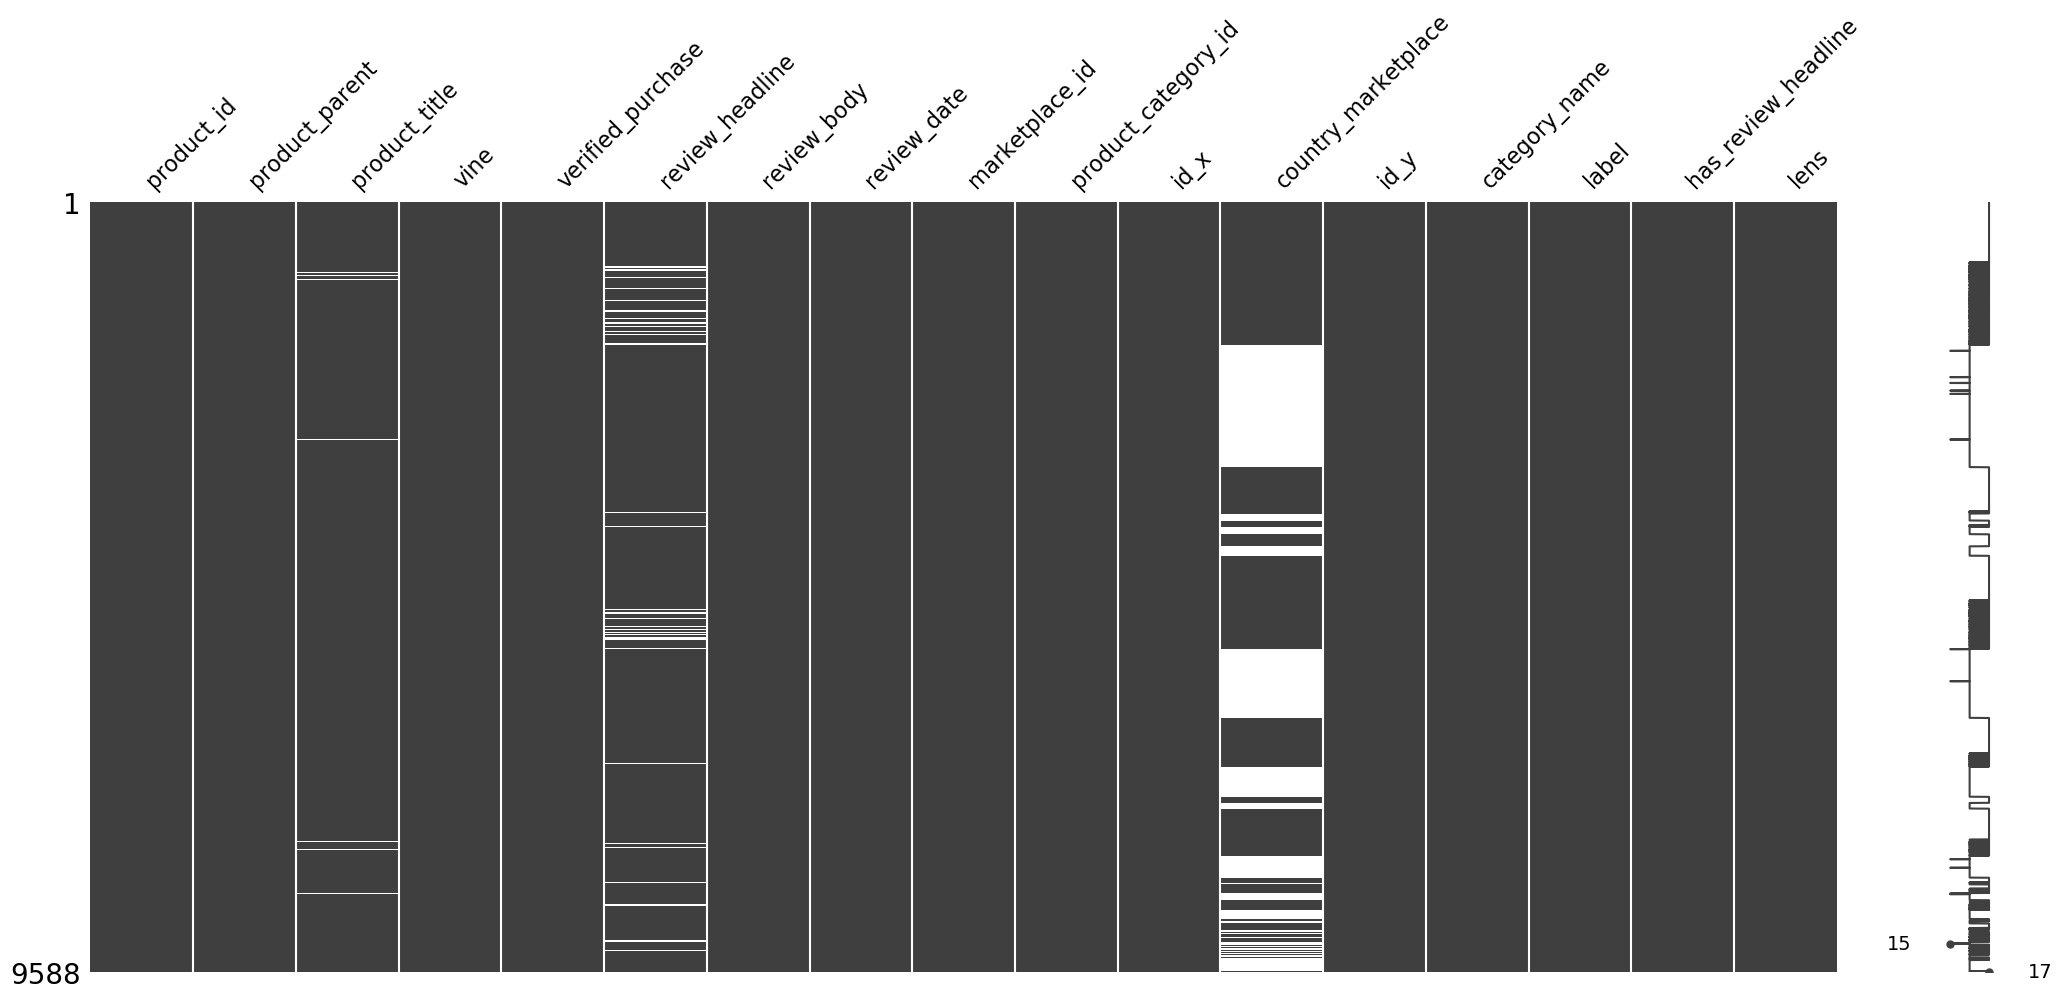

In [41]:
import missingno as mso

mso.matrix(df)
plt.show()

In [7]:
# df['review_date'] = df['review_date'].apply(pd.to_datetime)

In [63]:
df.head()

,product_id,product_parent,product_title,vine,verified_purchase,review_headline,review_body,review_date,category_name,label,has_review_headline,lens,country_name
,,,,,,,,,,,,,
9,B001N2MZT8,903886718,Green Zone [DVD],False,True,green zone,I found at first it was a little difficult to ...,2010-11-15,Video DVD,False,False,450,UK
145,B005ZC7BLO,501966104,Bones - Season 7 [DVD],False,True,Bones Season 7,If you already like Bones this may not be quit...,2012-12-12,Video DVD,False,False,110,UK
256,B000NTPCHE,671553677,To Catch A Thief [DVD] [1955],False,False,Lovely film,"I've always enjoyed this film, spectacular set...",2012-04-30,Video DVD,True,False,249,UK
938,B008BR79C6,410760130,Captain America [Blu-ray] [Region Free],False,True,Best of the Rest,"Surprised how much I enjoyed this movie, Capt ...",2014-03-12,Video DVD,False,False,113,UK
1097,B007I1QUYE,38597042,Spider-Man Trilogy [Blu-ray] [Region Free],False,True,AWESOME 3D,"WHAT A FANTASTIC MOVIE, WOW 3D IS AWESOME",2014-10-06,Video DVD,False,False,41,UK


In [122]:
qad_df = df.copy()
# delete_columns(qad_df, columns_to_delete=['product_id', 'product_title', 'vine', 'review_headline', 'review_body', 'review_date'])
qad_df = qad_df[[ 'verified_purchase', 'category_name', 'country_name', 'label', 'has_review_headline', 'lens']]
# qad_df = qad_df[[ 'verified_purchase', 'label', 'has_review_headline', 'lens']]

In [18]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [123]:
qad_df = encode_and_bind(encode_and_bind(qad_df, 'country_name'), 'category_name')

,verified_purchase,label,has_review_headline,lens,country_name_DE,country_name_FR,country_name_UK,category_name_Automotive,category_name_Baby,category_name_Books,...,category_name_PC,category_name_Personal_Care_Appliances,category_name_Shoes,category_name_Sports,category_name_Toys,category_name_Video,category_name_Video DVD,category_name_Video Games,category_name_Watches,category_name_Wireless
,,,,,,,,,,,,,,,,,,,,,
9,True,False,False,450,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
145,True,False,False,110,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
256,False,True,False,249,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
938,True,False,False,113,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1097,True,False,False,41,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [124]:
qad_df['verified_purchase'] = qad_df['verified_purchase'].apply(lambda x: 1 if x else 0)
qad_df['label'] = qad_df['label'].apply(lambda x: 1 if x else 0)
qad_df['has_review_headline'] = qad_df['verified_purchase'].apply(lambda x: 1 if x else 0)

In [ ]:
qad_df.head()

In [126]:
y = qad_df.pop('label')
X = qad_df

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [73]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [113]:
params_xg = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [3, 4, 5, 7],
        'learning_rate': [0.1, 0.01, 0.05],
        'n_estimators': [200, 1500, 2000],
        'bootstrap': [False, True],

        }

params_rf = {
        'max_depth': [3, 4, 5, 7, 10],
        'n_estimators': [200, 500, 1000, 1500, 2000],
        

        }

        # bootstrap=True, ccp_alpha=0.0, class_weight=None,
        #                criterion='gini', max_depth=None, max_features='auto',
        #                max_leaf_nodes=None, max_samples=None,
        #                min_impurity_decrease=0.0, min_impurity_split=None,
        #                min_samples_leaf=1, min_samples_split=2,
        #                min_weight_fraction_leaf=0.0, n_estimators=1000,
        #                n_jobs=None, oob_score=False, random_state=None,
        #                verbose=0, warm_start=False)

In [114]:
# clf = XGBClassifier(learning_rate=0.002, n_estimators=1000, objective='binary:logistic',
#                     silent=True, nthread=-1)

# clf = RandomForestClassifier()
clf = LGBMClassifier()

folds = 4
param_comb = 20

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(clf, param_distributions=params_xg, n_iter=param_comb, scoring='accuracy', n_jobs=-1, 
                                #    cv=skf.split(X,y), 
                                   verbose=3, random_state=1001)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.2s finished


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: bootstrap


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, s...
                   param_distributions={'bootstrap': [False, True],
                                        'gamma': [0.5, 1,

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

clf = LogisticRegression(solver='liblinear')
clf = SVC()


In [107]:
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [118]:
X_train.shape

(7671, 35)

In [142]:
import keras
import tensorflow

model2 = keras.Sequential([

    keras.layers.Dense(35, activation='sigmoid', input_shape=(35,)),
    
    keras.layers.Dense(512, activation='sigmoid'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),

    keras.layers.Dense(1, activation='sigmoid')

])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [143]:
model2.fit(X_train, y_train, epochs=10)

Epoch 1/10
240/240 [==============================] - 5s 17ms/step - loss: 0.6622 - acc: 0.5848
Epoch 2/10
240/240 [==============================] - 5s 20ms/step - loss: 0.5754 - acc: 0.7111
Epoch 3/10
240/240 [==============================] - 4s 18ms/step - loss: 0.5664 - acc: 0.7126: 0s - loss: 0.57
Epoch 4/10
240/240 [==============================] - 4s 17ms/step - loss: 0.5641 - acc: 0.7106
Epoch 5/10
240/240 [==============================] - 4s 17ms/step - loss: 0.5623 - acc: 0.7157
Epoch 6/10
240/240 [==============================] - 4s 18ms/step - loss: 0.5590 - acc: 0.7165
Epoch 7/10
240/240 [==============================] - 4s 18ms/step - loss: 0.5591 - acc: 0.7161
Epoch 8/10
240/240 [==============================] - 4s 18ms/step - loss: 0.5634 - acc: 0.7159: 0s - loss: 0.5655 - acc: 0.
Epoch 9/10
240/240 [==============================] - 4s 18ms/step - loss: 0.5546 - acc: 0.7195
Epoch 10/10
240/240 [==============================] - 6s 24ms/step - loss: 0.5575 - acc: 

In [135]:
y_pred = model2.predict(X_test)

In [132]:
accuracy_score(y_test, y_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [96]:
test_df = pd.read_csv('test_hidden.csv')
validation_df = pd.read_csv('validation_hidden.csv')

In [436]:
test_df = preprocess(test_df, is_train=False)

In [437]:
validation_df = preprocess(validation_df, is_train=False, pipeline=pipeline, model_st=model_st)

In [438]:
COLUMNS = qad_df.columns.tolist()

In [439]:
test_df = test_df[COLUMNS]

In [440]:
validation_df = validation_df[COLUMNS]

In [441]:
y_pred_test = random_search.predict(test_df)

In [442]:
y_pred_val = random_search.predict(validation_df)

In [443]:
y_pred_test = y_pred_test.astype(str)
y_pred_val = y_pred_val.astype(str)

In [444]:
np.savetxt("quick_and_dirty_test2.txt", y_pred_test, delimiter=",", fmt='%s')
np.savetxt("quick_and_dirty_val2.txt", y_pred_val, delimiter=",", fmt='%s')